# Airbnb Project

This notebook follows the CRISP-DM process as follows. <br>
> Business Understanding <br>
Data Understanding <br>
Prepare Data <br>
Data Modeling <br>
Evaluate the Results <br>

#### Business Understanding
The vacation rental industry has fierce competition. Owners have a large incentive to keep their listings occupied to maximize income. The following questions of interest are: <br>
> Question 1: Do Airbnb renters give bad reviews to listings that demand high fees?  <br> Question 2: Do Airbnb renters rent cheaper units more than expensive units?  <br> Question 3: How can Airbnb owners keep their listings occupied?


#### Data Understanding
This post will use dataset of nearly 4,000 listings in the Seattle area to predict successful listings. There are 92 attibutes of continuous, categorical, string, float, and datetime data types. We will focus on occupancy rate from this dataset to predict successful listings. 

First, import packages and get our dataset

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, roc_curve, confusion_matrix, auc
from sklearn import linear_model
from Binary_Classifier import evalBinaryClassifier
%matplotlib inline

dfl = pd.read_csv('./data_files/listings.csv')

#### Prepare Data

Convert currency & rate variables to float. 

In [3]:
# Convert currency & rate variables to float
dfl['price'] = dfl['price'].str.replace('$', '').str.replace(',', '').astype('float64')
dfl['weekly_price'] = dfl['weekly_price'].str.replace('$', '').str.replace(',', '').astype('float64')
dfl['monthly_price'] = dfl['monthly_price'].str.replace('$', '').str.replace(',', '').astype('float64')
dfl['security_deposit'] = dfl['security_deposit'].str.replace('$', '').str.replace(',', '').astype('float64')
dfl['cleaning_fee'] = dfl['cleaning_fee'].str.replace('$', '').str.replace(',', '').astype('float64')
dfl['host_response_rate'] = dfl['host_response_rate'].str.replace('%', '').astype('float64')

Get continuous variables. Reduce to those of interest (for example: remove id as they don't provide useful information)

In [4]:
# Get dataframe of only Continuous Columns
dfl_cont = dfl.select_dtypes(include=['float64', 'int64'])
# Drop square_feet and monthly_price due to lack of data
dfl_cont_int = dfl_cont.drop(columns=['id', 'scrape_id', 'host_id', 'square_feet', 'license', 'monthly_price', 'weekly_price', 'host_total_listings_count'])  

Impute means for continuous variables with null values

In [5]:
# Create mean function
fill_mean = lambda col: col.fillna(col.mean()) 
# Use function to Fill missing values with the mean of the column.
dfl_cont_imp = dfl_cont_int.apply(fill_mean, axis=0)  

Plot corr matrix to see if there are any insightful correlations between continuous variables.

Question 1 Answer: <br> 
> There is no correlation between the price of the listing and the review scores. This suggests positive reviews are independent of the expensiveness of the house or condo being rented (including cleaning fees, security fees, etc.). So people don’t give bad reviews just because they pay higher fees.

Question 2 Answer: <br> 
> There is also no correlation between room availability and price of listing, suggesting cheaper units do not get booked more than expensive ones.

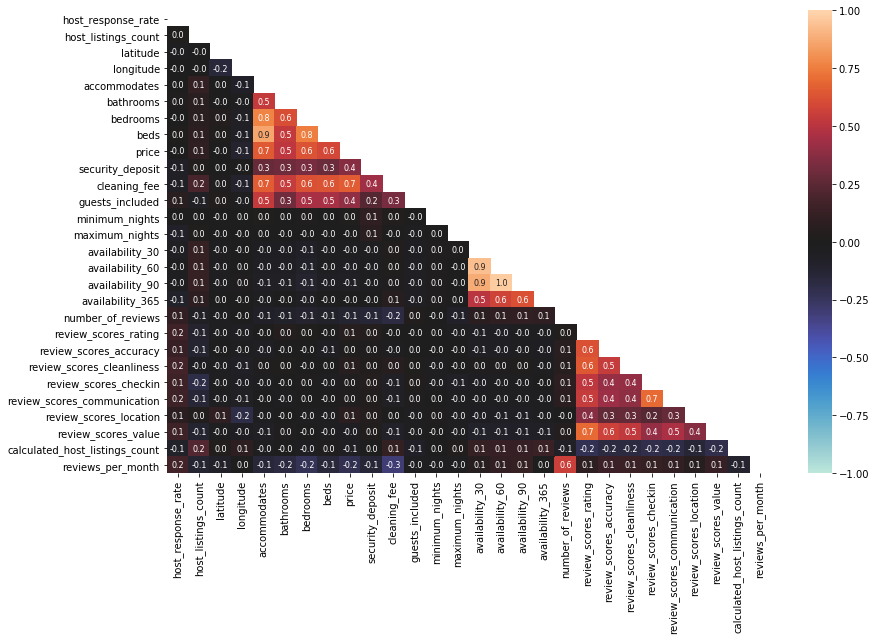

In [6]:
mask = np.triu(np.ones_like(dfl_cont_int.corr(), dtype=bool))  # only show half of corr plot
plt.figure(figsize=(13, 9))
sns.heatmap(dfl_cont_int.corr(), annot=True, fmt='.1f', vmin=-1, vmax=+1, center=0, annot_kws={"size": 8}, mask=mask).figure.tight_layout()
plt.show()

Get categorical variables. Create dummy variables from the categorical variables so they can be inputted into the model. 

In [7]:
# Get categorical variables of interest
dfl_categories = dfl.select_dtypes(include=['object'])
# dfl_categories.nunique()    # Reduced variables to those with unique values less than x
# dfl_categories['host_response_time'].value_counts()
dfl_categories_int = dfl_categories[['property_type', 'cancellation_policy', 'neighbourhood_group_cleansed', 'host_response_time']]

# Convert categorical variables of interest to dummy variables (1's and 0's)
cols = dfl_categories_int.columns
dummy = pd.get_dummies(dfl_categories_int[cols], prefix=cols, prefix_sep='_', drop_first=True, dummy_na=True)
# dummy.sum()

Combine continuous and categorical variables into one dataframe. Create response variable we want to predict. 

In [8]:
# Combine continuous and categorical variables
dfl_combined = pd.merge(dfl_cont_imp, dummy, left_index=True, right_index=True)

# Create a Response Variable or percentage of the time the listing is booked. Remove vars which are highly correlated to response.
dfl_combined['pct_booked_30'] = (1 - dfl['availability_30'] / 30)  # Add response variable (continuous)

Plot histogram and boxplot of response variable. In order to predict occupancy rate, lets first take a look at the response variable’s distribution. 

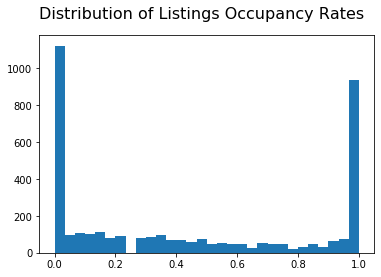

count    3818.000000
mean        0.440457
std         0.405788
min         0.000000
25%         0.000000
50%         0.333333
75%         0.933333
max         1.000000
Name: pct_booked_30, dtype: float64

In [9]:
# Plot histogram of dummy Response Variable
plt.suptitle('Distribution of Listings Occupancy Rates', fontsize=16)
histo = plt.hist(dfl_combined['pct_booked_30'], bins=30)
plt.show()

# Print boxplot
dfl_combined.describe()['pct_booked_30']  # Average occupancy rate of 44%

#### Data Modeling
We can modify our “Occupancy Rate” variable as follows: any listing with an occupancy rate less than 50% is set to 0, and any listing greater than 50% is set to 1. We will then try to predict failure (0) success (1) using a logistic regression model instead since success seems to be binary.

In [10]:
# 1) Solve over fitting issues (drop variables highly correlated with response variable)
dfl_final1 = dfl_combined.drop(columns=['availability_30', 'availability_60', 'availability_90',
                                        'availability_365'])  
# 2) Solve for Multicollinearity (variables that are highly correlated to each other) - NO CHANGE
dfl_final2 = dfl_final1.drop(columns=['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                                      'review_scores_communication', 'review_scores_location', 'review_scores_value'])
# 3) Create new binary response variable to try Logistic Regression
dfl_final3 = dfl_final1
dfl_final3['pct_booked_30_bnry'] = dfl_final3['pct_booked_30'].round()  # Add response variable (BINARY)
dfl_final3 = dfl_final3.drop(columns='pct_booked_30')

In [11]:
# Split data in train/test (BINARY occupancy rate)
y = dfl_final3['pct_booked_30_bnry']
x = dfl_final3.drop('pct_booked_30_bnry', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3,
                                                    random_state=42)  # random_state (keep value the same to recreate results)

In [12]:
# 1 - INSTANTIATE THE MODEL
model = LogisticRegression(max_iter= 50000)
# 2 - FIT THE MODEL TO THE TRAINING DATA SET
model.fit(x_train, y_train)
# 3 - PREDICT TEST DATA FROM THE MODEL
y_test_preds = model.predict(x_test)
# 4 - SCORE THE MODEL (BASED ON THE Y_TEST DATASET)
log_score = model.score(x_test, y_test)
print("The mean accuracy score (TEST fit) for your model was {} on {} values.".format(log_score, len(y_test)))    

The mean accuracy score (TEST fit) for your model was 0.6265270506108203 on 1146 values.


#### Evaluate Model
The confusion matrix (below left) shows we can predict successful landlords with 54% accuracy and unsuccessful landlords with 67% accuracy. The distributions of predictions (below middle) indicates there is some randomness in the model’s ability to predict successfulness.

Question 3 Answer: <br> 
> The Magnolia neighborhood, Bed & Breakfast listings, and Lake City are the top 3 variables which may lead to your Airbnb not being rented. <br> <br>
However, since the model does a better job at predicting “Not Successful” occupancy rates, we can infer some things to avoid for our landlords. The negative values displayed below are the most powerful variables at predicting zero occupancy rates.  <br> <br>
> On the positive side, if you live in the Cascade area and are considering renting it out on Airbnb, then you have a good opportunity for a steady stream of income!

In [16]:
# Evaluate coefficients
coefs_df = pd.DataFrame()
coefs_df['est_int'] = x_train.columns
coefs_df['coefs'] = np.transpose(model.coef_.tolist()[0])   # transpose needed for Logistic Regression only
coefs_df['abs_coefs'] = coefs_df['coefs'].abs()
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
print(coefs_df.head(20).to_string())

                                             est_int     coefs  abs_coefs
45              neighbourhood_group_cleansed_Cascade  0.923980   0.923980
51             neighbourhood_group_cleansed_Magnolia -0.909763   0.909763
24                     property_type_Bed & Breakfast -0.743517   0.743517
26                            property_type_Bungalow -0.719397   0.719397
50            neighbourhood_group_cleansed_Lake City -0.670943   0.670943
34                               property_type_Other -0.658154   0.658154
63                            host_response_time_nan  0.552533   0.552533
36                           property_type_Townhouse -0.533224   0.533224
57  neighbourhood_group_cleansed_University District -0.380250   0.380250
62                 host_response_time_within an hour -0.355164   0.355164
55       neighbourhood_group_cleansed_Rainier Valley  0.308973   0.308973
32                               property_type_House -0.298189   0.298189
49             neighbourhood_group_cle

In [18]:
# Show descriptive statistics indicating why Cascade Neighborhood is the best predictor of 100% occupancy rates.
dfl['neighbourhood_group_cleansed'].value_counts()
dfl['pct_booked_30'] = (1 - dfl['availability_30'] / 30)
dfl.groupby(['neighbourhood_group_cleansed']).describe()['pct_booked_30']

count      mean       std  min       25%  \
neighbourhood_group_cleansed                                             
Ballard                       230.0  0.477971  0.401583  0.0  0.066667   
Beacon Hill                   118.0  0.406780  0.400512  0.0  0.000000   
Capitol Hill                  567.0  0.466255  0.409254  0.0  0.033333   
Cascade                        89.0  0.558427  0.419363  0.0  0.133333   
Central Area                  369.0  0.476874  0.415296  0.0  0.000000   
Delridge                       79.0  0.391983  0.408256  0.0  0.000000   
Downtown                      530.0  0.402390  0.365238  0.0  0.066667   
Interbay                       11.0  0.169697  0.313565  0.0  0.000000   
Lake City                      67.0  0.330348  0.389195  0.0  0.000000   
Magnolia                       61.0  0.255738  0.379752  0.0  0.000000   
Northgate                      80.0  0.465000  0.426014  0.0  0.000000   
Other neighborhoods           794.0  0.451134  0.418504  0.0  0.000000   
Queen Anne                    295.0  0.505537  0.404430  0.0  0.066667   
Rainier Valley                159.0  0.436268  0.403577  0.0  0.033333   
Seward Park                    44.0  0.351515  0.380972  0.0  0.000000   
University District           122.0  0.308197  0.379268  0.0  0.000000   
West Seattle                  203.0  0.408374  0.409554  0.0  0.000000   

                                   50%       75%       max  
neighbourhood_group_cleansed                                
Ballard                       0.366667  0.966667  1.000000  
Beacon Hill                   0.300000  0.891667  1.000000  
Capitol Hill                  0.366667  1.000000  1.000000  
Cascade                       0.633333  1.000000  1.000000  
Central Area                  0.400000  1.000000  1.000000  
Delridge                      0.233333  0.800000  1.000000  
Downtown                      0.300000  0.700000  1.000000  
Interbay                      0.000000  0.200000  0.966667  
Lake City                     0.166667  0.550000  1.000000  
Magnolia                      0.000000  0.466667  1.000000  
Northgate                     0.350000  0.966667  1.000000  
Other neighborhoods           0.333333  1.000000  1.000000  
Queen Anne                    0.466667  1.000000  1.000000  
Rainier Valley                0.333333  0.950000  1.000000  
Seward Park                   0.216667  0.675000  1.000000  
University District           0.116667  0.558333  1.000000  
West Seattle                  0.300000  0.933333  1.000000

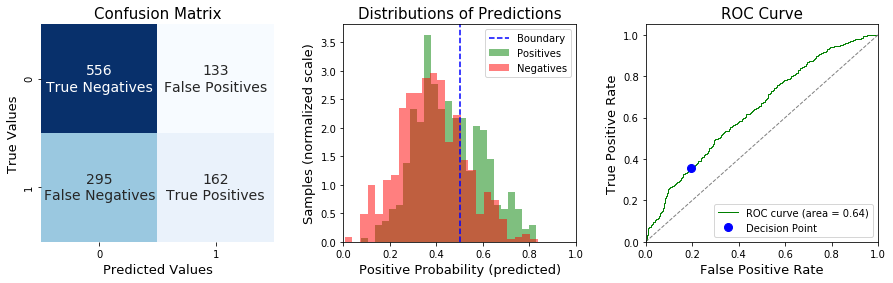

Precision: 0.55 | Recall: 0.35 | F1 Score: 0.43 | 


0.0    0.601222
1.0    0.398778
Name: pct_booked_30_bnry, dtype: float64

In [15]:
# Evaluate Logistic Regression - Classifier Model
F1 = evalBinaryClassifier(model, x_test, y_test)
y_test.value_counts()/y_test.shape[0]   # percent of neg and pos